# Sprint 1: Formalización del problema

## Espacio de codificación de soluciones


## Codificación de soluciones


In [ ]:
### Propón algunas soluciones al problema como ejemplo
sol_1=[]
sol_2=[]

### Función objetivo


Número de autores en el grafo: 4
Número de aristas en el grafo: 2


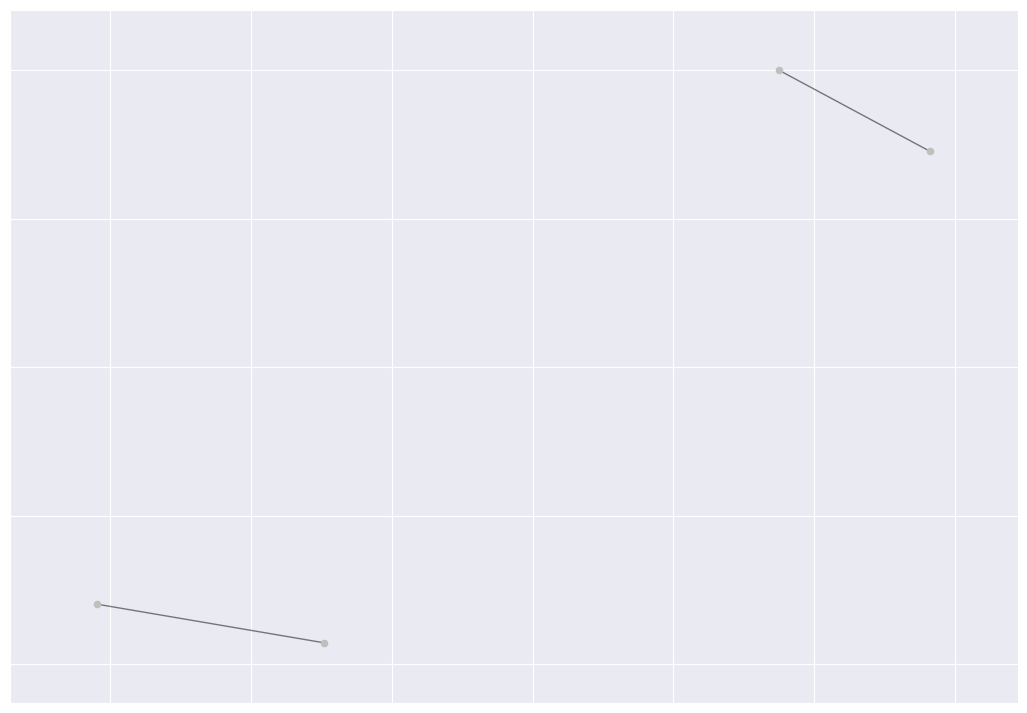

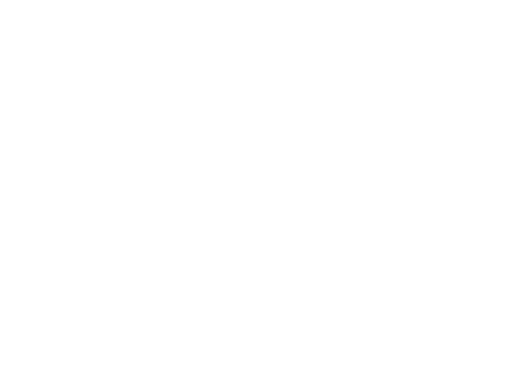

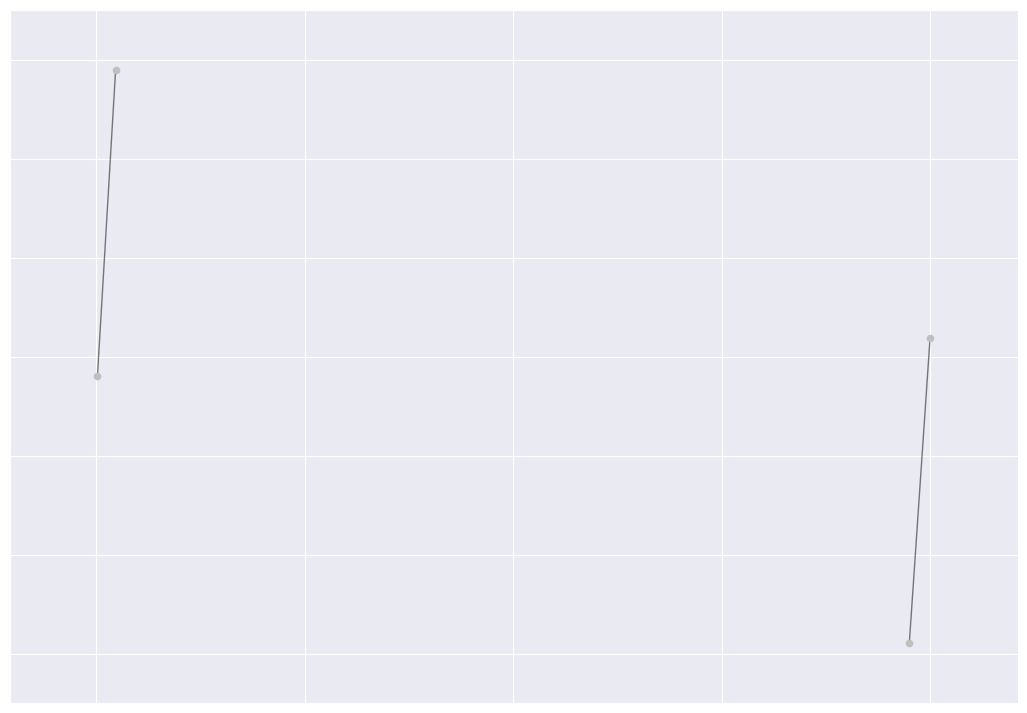

NameError: name 'sol_1' is not defined

In [4]:
import import_ipynb  # <-- Importar esto PRIMERO

# Ahora importa tu notebook
import CDP_0_SRC
from itertools import product
import community
import networkx as nx
import numpy as np

### Función objetivo
def modularidad(G, particion, weight='weight'):
    
    ### TODO 15-20 lineas
    
    return fitness

### llamadas generales

G = CDP_0_SRC.crear_grafo()

## nuestra implementación
partition1 = dict(zip(G.nodes, sol_1))
partition2 = dict(zip(G.nodes, sol_2))

print("Fitness solucion 1: {} ".format(modularidad(G, partition1)))
print("Fitness solucion 2: {} ".format(modularidad(G, partition2)))